In [6]:
# Importing the required libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [7]:
# loading the datasets
total_rows = 5432339  
rows_to_load = int(total_rows * 0.15)
# Load approximately 15% of the historical data
historical_data_sampled = pd.read_csv(
    'Law_Enforcement_Dispatched_Calls_for_Service__Closed.csv', 
    parse_dates=['received_datetime', 'close_datetime'],
    nrows=rows_to_load
)
real_time_data = pd.read_csv('Law_Enforcement_Dispatched_Calls_for_Service__Real-Time.csv', parse_dates=[
    'received_datetime', 'entry_datetime', 'dispatch_datetime', 
    'enroute_datetime', 'onscene_datetime', 'close_datetime', 
    'call_last_updated_at', 'data_as_of', 'data_loaded_at'])

In [8]:
# considering with the sample percent of the historical data as the data is so huge 
historical_data_sampled = historical_data_sampled.sample(frac=0.15, random_state=42)

# Normalizing for the numerical data
def normalize_column(data, column_name):
    scaler = MinMaxScaler()
    data[column_name + '_normalized'] = scaler.fit_transform(data[[column_name]])
    
normalize_column(historical_data_sampled, 'cad_number')
normalize_column(real_time_data, 'cad_number')

# Calculating the call duration in the historical_data_sampled dataset
historical_data_sampled['call_duration'] = (historical_data_sampled['close_datetime'] - historical_data_sampled['received_datetime']).dt.total_seconds()
normalize_column(historical_data_sampled, 'call_duration')

# Assuming real_time_data was loaded and needs the same treatment as historical_data_sampled
real_time_data['call_duration'] = (real_time_data['close_datetime'] - real_time_data['received_datetime']).dt.total_seconds()
normalize_column(real_time_data, 'call_duration')

In [9]:
print(real_time_data.columns)

Index(['id', 'cad_number', 'received_datetime', 'entry_datetime',
       'dispatch_datetime', 'enroute_datetime', 'onscene_datetime',
       'close_datetime', 'call_type_original', 'call_type_original_desc',
       'call_type_original_notes', 'call_type_final', 'call_type_final_desc',
       'call_type_final_notes', 'priority_orginal', 'priority_final', 'agency',
       'disposition', 'onview_flag', 'sensitive_call', 'intersection_name',
       'intersection_id', 'intersection_point', 'supervisor_district',
       'analysis_neighborhood', 'police_district', 'call_last_updated_at',
       'data_as_of', 'data_loaded_at', 'cad_number_normalized',
       'call_duration', 'call_duration_normalized'],
      dtype='object')


In [10]:
print(real_time_data[['cad_number_normalized', 'call_duration_normalized']].describe())

       cad_number_normalized  call_duration_normalized
count            3005.000000               2619.000000
mean                0.998906                  0.005874
std                 0.018303                  0.021154
min                 0.000000                  0.000000
25%                 0.998951                  0.001045
50%                 0.999085                  0.002646
75%                 0.999829                  0.006396
max                 1.000000                  1.000000


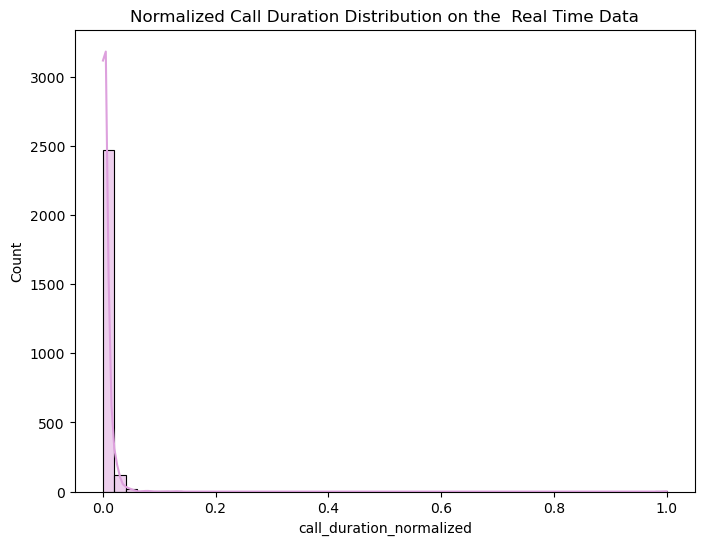

In [11]:
# Visualizing call durations on real data 
plt.figure(figsize=(8, 6))
sns.histplot(real_time_data['call_duration_normalized'], bins=50, kde=True, color='plum')
plt.title('Normalized Call Duration Distribution on the  Real Time Data')
plt.show()

The histogram of normalized call durations for real-time data shows that most calls are quite short. The tall bar at 0.0 on the left side of the histogram shows this. The distribution is heavily skewed to the right with a long tail, indicating that most calls are resolved fast and few calls takes long time.

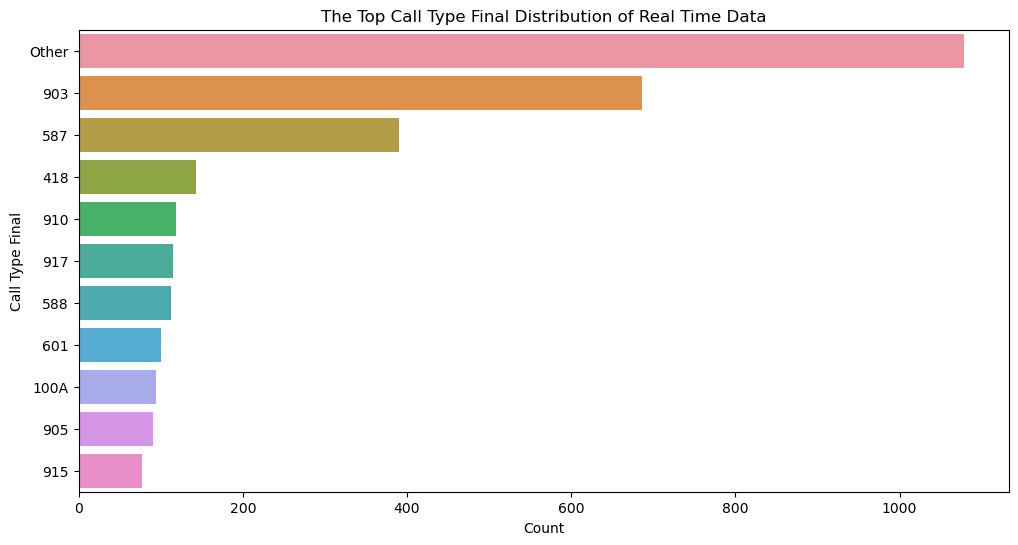

In [12]:
# Counting the frequencies of each category in 'call_type_final'
call_type_counts = real_time_data['call_type_final'].value_counts()

# Determining only the top N categories
top_n = 10
top_call_types = call_type_counts.head(top_n).index

# Creating a new column that combines all non-top categories into 'Other'
real_time_data['call_type_final_top_n'] = real_time_data['call_type_final'].apply(lambda x: x if x in top_call_types else 'Other')
plt.figure(figsize=(12, 6))  
sns.countplot(y='call_type_final_top_n', 
              data=real_time_data, 
              order=real_time_data['call_type_final_top_n'].value_counts().index)  # Ordering bars by count
plt.title('The Top Call Type Final Distribution of Real Time Data')
plt.xlabel('Count')
plt.ylabel('Call Type Final')
plt.show()

The histogram of normalized call durations for real-time data shows that most calls are quite short. The tall bar at 0.0 on the left side of the histogram shows this. The distribution is heavily skewed to the right with a long tail, indicating that most calls are resolved fast and few calls takes long time.

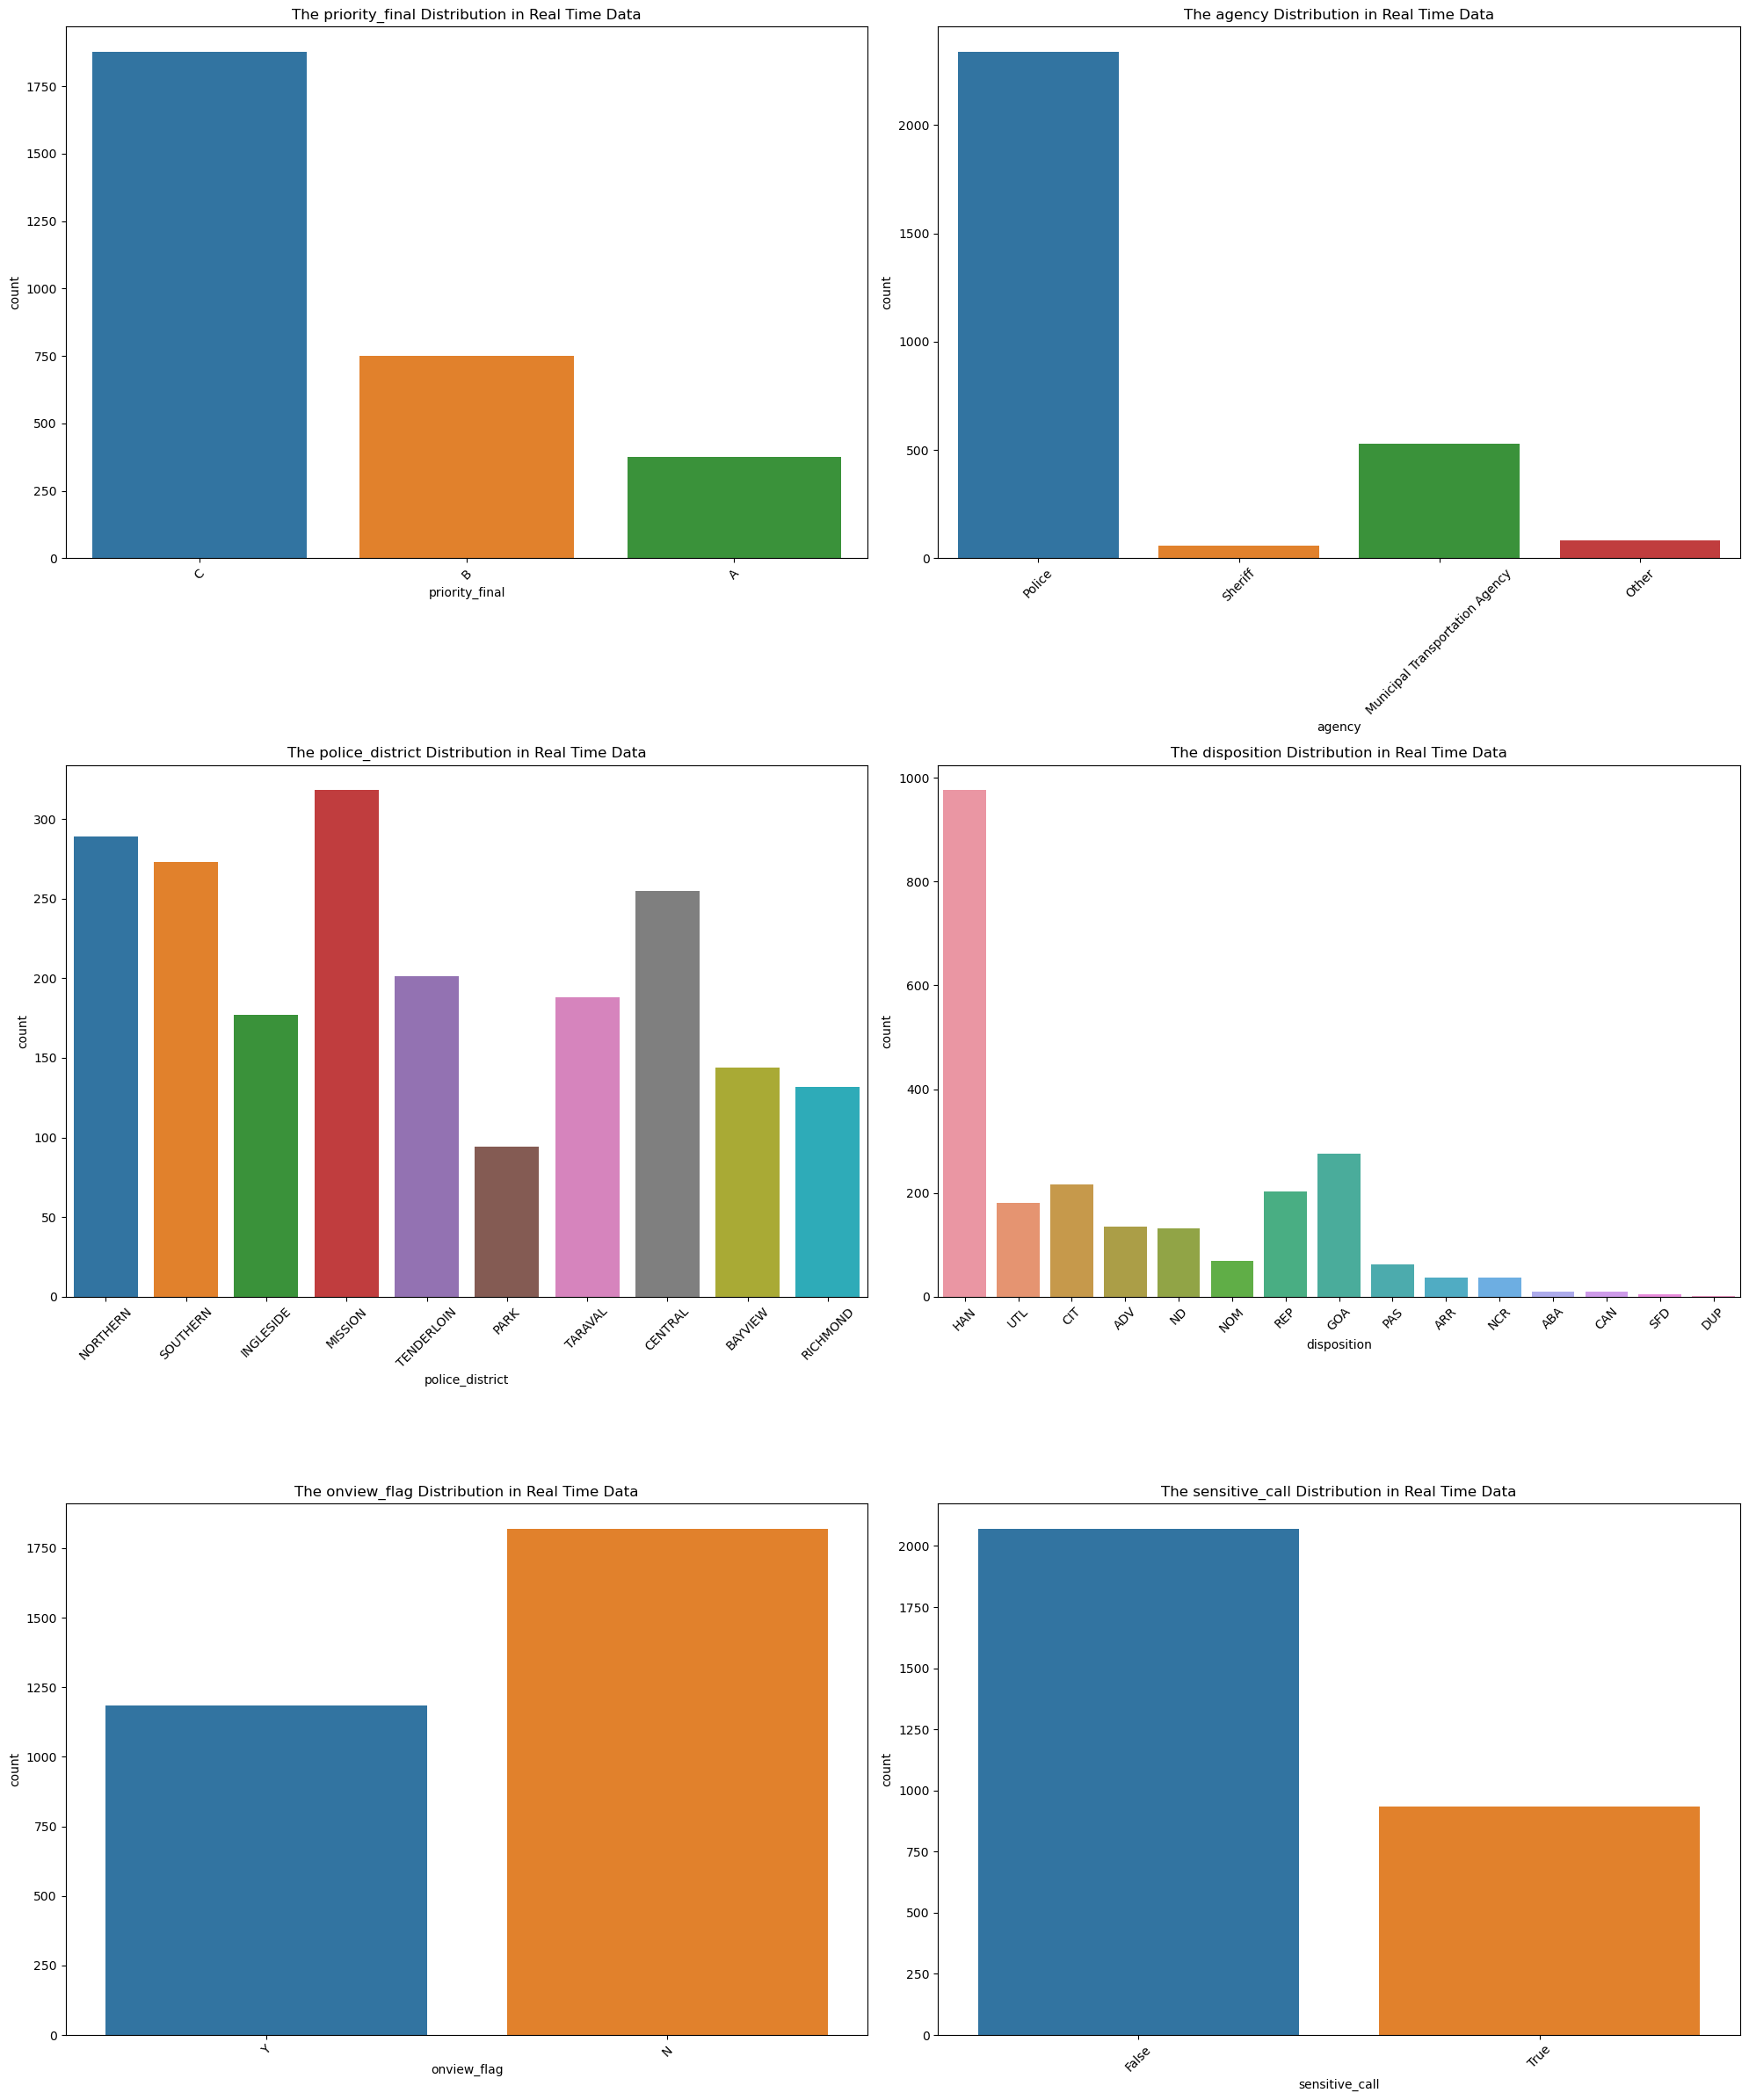

In [13]:
categorical_columns = [
    'priority_final', 'agency', 'police_district',
    'disposition', 'onview_flag', 'sensitive_call'
]
n_cols = 2  # Number of columns in the plot grid
n_rows = (len(categorical_columns) + n_cols - 1) // n_cols  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 8 * n_rows))
axes = axes.flatten()

# Creating the count plots for each categorical columns
for i, column in enumerate(categorical_columns):
    sns.countplot(x=column, data=real_time_data, ax=axes[i])
    axes[i].set_title(f'The {column} Distribution in Real Time Data')
    axes[i].tick_params(axis='x', rotation=45)  # Rotate the x-tick labels

# If the number of plots is not evenly divisible by the number of columns, remove the last ax
if len(axes) > len(categorical_columns):
    fig.delaxes(axes[-1]) 
plt.tight_layout()
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
exclude_columns = [
    'received_datetime', 'entry_datetime', 'dispatch_datetime', 
    'enroute_datetime', 'onscene_datetime', 'close_datetime', 
    'call_duration', 'call_duration_normalized'
]
X = real_time_data.drop(exclude_columns, axis=1)
y = real_time_data['call_duration_normalized']
imputer_y = SimpleImputer(missing_values=np.nan, strategy='mean')
y_imputed = imputer_y.fit_transform(y.values.reshape(-1, 1)).flatten()
non_numeric_columns = X.select_dtypes(include=['object', 'datetime']).columns.tolist()
X = pd.get_dummies(X, columns=non_numeric_columns)

#using mean imputer
imputer_X = SimpleImputer(missing_values=np.nan, strategy='mean')

#to handle nan values
X_imputed = imputer_X.fit_transform(X)

# Split the data into training and testing sets with a 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y_imputed, test_size=0.3, random_state=42)

#using the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# calculating the mean squared error
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"The linear model achieved Mean Squared Error: {mse}")

The linear model achieved Mean Squared Error: 0.00040495372886829384


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import pandas as pd

# Define datetime columns
datetime_columns = [
    'received_datetime', 'entry_datetime', 'dispatch_datetime', 
    'enroute_datetime', 'onscene_datetime', 'close_datetime'
]

# Extract datetime columns and convert to numerical features
X_datetime = real_time_data[datetime_columns]
for col in datetime_columns:
    # Assuming the datetime columns are already in datetime format
    X_datetime[col + '_year'] = X_datetime[col].dt.year
    X_datetime[col + '_month'] = X_datetime[col].dt.month
    X_datetime[col + '_day'] = X_datetime[col].dt.day
    X_datetime[col + '_hour'] = X_datetime[col].dt.hour
    X_datetime[col + '_minute'] = X_datetime[col].dt.minute
    X_datetime[col + '_second'] = X_datetime[col].dt.second

# Drop the original datetime columns as they have been converted
X_datetime = X_datetime.drop(columns=datetime_columns)

# Drop datetime and non-numeric columns from the original dataframe
X_numeric = real_time_data.select_dtypes(include=['number'])

# Impute missing values for numerical columns only
imputer_numeric = SimpleImputer(strategy='mean')
X_numeric_imputed = imputer_numeric.fit_transform(X_numeric)
X_numeric_imputed_df = pd.DataFrame(X_numeric_imputed, columns=X_numeric.columns)

# Combine numerical and transformed datetime columns
X_combined = pd.concat([X_numeric_imputed_df, X_datetime.reset_index(drop=True)], axis=1)

# Extract target variable
y = real_time_data['priority_final']

# Splitting the data into training and testing sets (70:30)
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

# Training the Decision Tree Classifier
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

# Getting the accuracy of the model
y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"The model has achieved an Accuracy: {accuracy:.2f}")

The model has achieved an Accuracy: 0.61


/var/folders/7k/6cstz_hn07v2qs5pwf2p3gpm0000gn/T/ipykernel_1430/2582505731.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_datetime[col + '_year'] = X_datetime[col].dt.year
/var/folders/7k/6cstz_hn07v2qs5pwf2p3gpm0000gn/T/ipykernel_1430/2582505731.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_datetime[col + '_month'] = X_datetime[col].dt.month
/var/folders/7k/6cstz_hn07v2qs5pwf2p3gpm0000gn/T/ipykernel_1430/2582505731.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

The independent t-test p-value is 0.320, greater than the 0.05 alpha level. This means we lack evidence to reject the null hypothesis. This test shows that Category A and Category B had similar mean response times in the simulated data.

In [2]:
# Simulating data
np.random.seed(0)
data_simulated_2 = pd.DataFrame({
    'age': np.random.randint(20, 60, size=100),
    'income': np.random.normal(loc=50000, scale=10000, size=100)
})

# Computing the Pearson correlation coefficient and p-value
corr_coefficient, p_value_corr = stats.pearsonr(data_simulated_2['age'], data_simulated_2['income'])

# Showing the results
print("Correlation Coefficient:", corr_coefficient)
print("P-Value:", p_value_corr)

Correlation Coefficient: -0.056814069074484205
P-Value: 0.574489747519209
